## League of Legends European Championship 2015 - 2022 Data Scraping

Zaimportowanie bibliotek

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
lec_data = pd.DataFrame(columns=['Place','Team','Games','Games %','Streak'])

Stworzenie funkcji pozwalającej na pobranie danych dotyczących każdego sezonu w Europejskich rozgrywkach w grze League of Legends w latach 2015 - 2022. Dane zawierają informacje jedynie o sezonach regularnych.
Źródło danych - https://lol.fandom.com/wiki/

In [3]:
def get_data_per_year(lec_data, year):
    if not 2014 <= year <= 2022:
        raise ValueError("Dane z podanego roku nie beda poprawne!\n")

    url = f"https://lol.fandom.com/wiki/EU_LCS/{year}_Season"
    if year > 2018:
        url = f"https://lol.fandom.com/wiki/LEC/{year}_Season"

    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    seasons = soup.find_all('table',class_="wikitable2")
    if not seasons:
        print(f"Nie znaleziono danych dla {year} roku.\n")
        return data
    
    data = pd.DataFrame(columns=['Place','Team','Games','Games %','Streak'])
    
    for season in seasons:
        split = ""
        df = pd.read_html(str(season))[0]
        df = df[3:]
        
        if "Spring" in df.columns[1][0][:20]:
            split = "Spring"
        elif "Summer" in df.columns[1][0][:20]:
            split = "Summer"

        columns = df.columns[df.isin(['Series', 'Pts']).any()]
        df = df.drop(columns, axis=1)

        df.columns = ['Place','Team','Games','Games %','Streak']
        df['Split'] = split
        df['Year'] = year
        data = pd.concat([data, df], ignore_index=True)
    return data

In [4]:
for i in range(2015,2023):    
    lec_data = pd.concat([lec_data, get_data_per_year(lec_data, i)], ignore_index=True)

In [5]:
lec_data.head()

,Place,Team,Games,Games %,Streak,Split,Year
0,Promotion Tournament,NaN,NaN,NaN,NaN,Spring,2015.0
1,Relegated,NaN,NaN,NaN,NaN,Spring,2015.0
2,NaN,Team,Games,Games,Str,Spring,2015.0
3,1,⁠⁠SK Gaming,15 - 3,83%,7W,Spring,2015.0
4,2,⁠⁠Fnatic,13 - 5,72%,2W,Spring,2015.0


Obróbka danych

In [6]:
lec_data = lec_data.dropna()
lec_data[['Wins', 'Losses']] = lec_data['Games'].str.split('-', expand=True)


lec_data['Wins'] = lec_data['Wins'].astype(int)
lec_data['Losses'] = lec_data['Losses'].astype(int)
lec_data['Year'] = lec_data['Year'].astype(int)
lec_data['Place'] = lec_data['Place'].astype(int)

lec_data['Games %'] = lec_data['Games %'].str.replace('%', '')
lec_data['Games %'] = lec_data['Games %'].astype(float)

lec_data = lec_data.drop(columns=['Games'])
lec_data.head()

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
3,1,⁠⁠SK Gaming,83.0,7W,Spring,2015,15,3
4,2,⁠⁠Fnatic,72.0,2W,Spring,2015,13,5
5,3,⁠⁠H2k-Gaming,67.0,1W,Spring,2015,12,6
6,4,⁠⁠Gambit Gaming,56.0,1L,Spring,2015,10,8
7,5,⁠⁠Unicorns of Love,50.0,2L,Spring,2015,9,9


In [7]:
lec_data.to_csv('lec_data.csv', index = False)

In [8]:
import re
pattern = re.compile(r'(\d+)')

Zmiana wartosci w kolumnie 'Streak' na wartości liczbowe:

    - > 0 oznaczają ilość zwycięstw pod rząd 
    - < 0 ilość przegranych pod rząd

In [9]:
def convert_streak(streak):
    match = pattern.search(streak)
    if match:
        num = int(match.group())
        if streak.endswith('W'):
            return num
        elif streak.endswith('L'):
            return -num
        elif streak.endswith('D'):
            return num
    return streak

lec_data['Streak'] = lec_data['Streak'].apply(convert_streak)
lec_data['Streak'] = pd.to_numeric(lec_data['Streak'], errors='coerce')
lec_data['Streak'] = lec_data['Streak'].astype(int)

In [10]:
lec_data.head()

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
3,1,⁠⁠SK Gaming,83.0,7,Spring,2015,15,3
4,2,⁠⁠Fnatic,72.0,2,Spring,2015,13,5
5,3,⁠⁠H2k-Gaming,67.0,1,Spring,2015,12,6
6,4,⁠⁠Gambit Gaming,56.0,-1,Spring,2015,10,8
7,5,⁠⁠Unicorns of Love,50.0,-2,Spring,2015,9,9


Najczęściej wygrywające drużyny

In [11]:
first_place = lec_data[lec_data['Place'] == 1]
first_place

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
3,1,⁠⁠SK Gaming,83.0,7,Spring,2015,15,3
16,1,⁠⁠Fnatic,100.0,18,Summer,2015,18,0
29,1,⁠⁠G2 Esports,83.0,7,Spring,2016,15,3
42,1,⁠⁠G2 Esports,78.0,1,Summer,2016,28,8
54,1,⁠⁠G2 Esports,76.0,-1,,2017,25,8
61,1,⁠⁠Unicorns of Love,74.0,6,,2017,23,8
68,1,⁠⁠Fnatic,79.0,1,,2017,23,6
75,1,⁠⁠H2k-Gaming,72.0,-1,,2017,21,8
81,1,⁠⁠Fnatic,78.0,5,Spring,2018,14,4
92,1,⁠⁠Fnatic,72.0,-1,Summer,2018,13,5


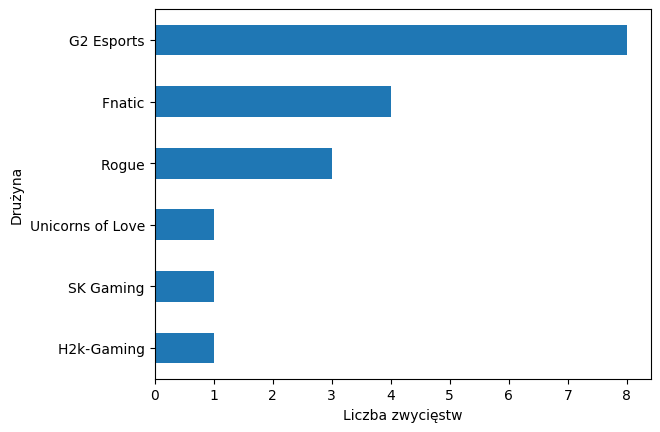

In [12]:
teams = first_place.groupby('Team').size()
teams = teams.sort_values(ascending=True)
teams.plot(kind='barh')


plt.ylabel('Drużyna')
plt.xlabel('Liczba zwycięstw')
plt.show()

Drużyny z największą i najmniejszą ilością zwycięstw

In [13]:
lec_data.sort_values(by = 'Wins',ascending=False).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
42,1,⁠⁠G2 Esports,78.0,1,Summer,2016,28,8


In [14]:
lec_data.sort_values(by = 'Wins',ascending=True).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
101,10,⁠⁠H2k-Gaming,11.0,1,Summer,2018,2,16


Drużyny z największą i najmniejszą ilością przegranych

In [15]:
lec_data.sort_values(by = 'Losses',ascending=False).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
65,5,⁠⁠Origen,7.0,-13,,2017,2,26


In [16]:
lec_data.sort_values(by = 'Losses',ascending=True).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
16,1,⁠⁠Fnatic,100.0,18,Summer,2015,18,0


Drużyny z największą i najmniejszą serią zwycięstw

In [17]:
lec_data.sort_values(by = 'Streak',ascending=False).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
16,1,⁠⁠Fnatic,100.0,18,Summer,2015,18,0


In [18]:
lec_data.sort_values(by = 'Streak',ascending=True).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
65,5,⁠⁠Origen,7.0,-13,,2017,2,26


Drużyny z największym i najmniejszym procentem zwycięstw

In [19]:
lec_data.sort_values(by = 'Games %',ascending=False).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
16,1,⁠⁠Fnatic,100.0,18,Summer,2015,18,0


In [20]:
lec_data.sort_values(by = 'Streak',ascending=True).head(1)

,Place,Team,Games %,Streak,Split,Year,Wins,Losses
65,5,⁠⁠Origen,7.0,-13,,2017,2,26


Średnie statystki drużyn na przełomie lat 2015 - 2022

In [21]:
lec_grouped = lec_data[['Place','Team','Games %','Streak','Wins','Losses']].groupby('Team').mean().sort_values(by = 'Place')
lec_grouped

,Place,Games %,Streak,Wins,Losses
Team,,,,,
⁠⁠G2 Esports,1.785714,71.285714,2.071429,15.285714,6.142857
⁠⁠Fnatic,3.000000,65.875000,2.312500,13.562500,7.375000
⁠⁠MAD Lions,3.500000,60.333333,0.833333,10.833333,7.166667
⁠⁠Rogue,3.625000,57.625000,-0.625000,10.375000,7.625000
⁠⁠H2k-Gaming,3.750000,57.750000,1.250000,13.750000,9.375000
⁠⁠Splyce,4.000000,55.750000,-0.750000,13.125000,10.000000
⁠⁠Unicorns of Love,5.000000,51.125000,0.375000,12.750000,11.250000
⁠⁠Ninjas in Pyjamas,5.000000,24.000000,1.000000,7.000000,22.000000
⁠⁠Mysterious Monkeys,5.000000,18.000000,-5.000000,5.000000,23.000000


Najczęściej występujące drużyny w rozgrywkach

In [22]:
lec_grouped2 = lec_data[['Place','Team']].groupby('Team').count().sort_values(by = 'Place', ascending = False)
lec_grouped2

,Place
Team,
⁠⁠Fnatic,16
⁠⁠Team Vitality,14
⁠⁠G2 Esports,14
⁠⁠Misfits Gaming,12
⁠⁠SK Gaming,10
⁠⁠Schalke 04,9
⁠⁠Origen,8
⁠⁠Team ROCCAT,8
⁠⁠Splyce,8
